# [Basic Introduction to Julia](https://ucidatascienceinitiative.github.io/IntroToJulia/) Notes
(tutorial by Chris Rackauckas)

## Starter problems

### Strang matrix problem

In [1]:
using Test

In [2]:
function strang_matrix(N)
    if N <= 0
        return Array{Float64, 2}(undef, 0, 0)
    elseif N == 1
        return fill(-2., (1,1))
    end
    
    result = zeros(N,N)
    result[1,1] = result[end,end] = -2.
    result[2,1] = result[end-1,end] = 1.

    for i=2:(N-1)
        result[i-1, i] = result[i+1, i] = 1.
        result[i,i] = -2.
    end
    return result
end;

In [3]:
@test strang_matrix(0) == Array{Float64, 2}(undef, 0, 0)
@test strang_matrix(1) == -2 * ones(1,1)
@test strang_matrix(2) == [ -2  1
                             1 -2 ]
@test strang_matrix(3) == [ -2  1  0
                             1 -2  1
                             0  1 -2 ]
@test strang_matrix(4) == [ -2  1  0  0
                             1 -2  1  0
                             0  1 -2  1
                             0  0  1 -2 ]

Test Passed

### Factorial Problem

In [4]:
function my_factorial(N)
    result = typeof(N)(1)
    for i = 2:N
        result *= i
    end
    return result
end;

In [5]:
@test my_factorial.([0, 1, 2, 3, 4, 5]) == [1, 1, 2, 6, 24, 120]

Test Passed

In [6]:
my_factorial(big(50))

30414093201713378043612608166064768844377641568960512000000000000

### Binomial problem

In [7]:
function binomial_rv(n, p)
    return count(x -> x <= p, rand(Float64, n))
end;

In [8]:
n = 1000000
p = 0.7
μ = n * p
σ = √(n*p*(1-p))
@test binomial_rv(n, p) ≈ μ atol=3σ

Test Passed

In [9]:
@time binomial_rv(1000000, 0.7);
@time rand(Float64, 1000000);

  0.003466 seconds (7 allocations: 7.630 MiB)
  0.009480 seconds (111 allocations: 7.636 MiB, 28.34% gc time)


### Monte Carlo $\pi$ problem

In [10]:
function mc_pi(N)
    p::Array{Float64,1} = rand(Float64, 2N)

    total = 0
    for i in 1:N
        @inbounds if (p[2i] * p[2i] + p[2i-1] * p[2i-1] < 1)
            total += 1
        end
    end
    return 4 * total/N
end;

In [22]:
mc_pi(10^3) # prime the JIT
@time mc_pi(10^9)

  9.619975 seconds (8 allocations: 14.901 GiB, 2.55% gc time)


3.1416467

#### playing with optimization...

In [34]:
function mc_pi_batched(N, batch_size=1000)
    total = 0.
    for i in 1:batch_size:N
        n = min(batch_size, N - i + 1)
        total += n*mc_pi(n)
    end
    return total/N
end;

In [35]:
mc_pi_batched(10^3) # prime the JIT
@time mc_pi_batched(10^9)

  9.329956 seconds (1.00 M allocations: 15.020 GiB, 8.12% gc time)


3.1416469

In [36]:
using Base.Threads
function mc_pi_threaded(N, batch_size=100000)
    total = Atomic{Float64}(0.)
    @threads for i in 1:batch_size:N
        n = min(batch_size, N - i + 1)
        atomic_add!(total, n*mc_pi(n))
    end
    return total[]/N
end;

In [37]:
mc_pi_threaded(10^3) # prime the JIT
@time mc_pi_threaded(10^9)

  0.658400 seconds (19.92 k allocations: 14.807 GiB)


3.14154142

In [38]:
using Base.Threads
using Random
import Future

function mc_pi(N, rng)
    p::Array{Float64,1} = rand(rng, Float64, 2N)

    total = 0
    for i in 1:N
        @inbounds if (p[2i] * p[2i] + p[2i-1] * p[2i-1] < 1)
            total += 1
        end
    end
    return 4 * total/N
end;

function mc_pi_randjump(N, batch_size=100000)
    m = MersenneTwister(1)
    r = [m]
    for i in 2:nthreads()
        push!(r, Future.randjump(m, big(10)^20))
    end
    total = Atomic{Float64}(0.)
    @threads for i in 1:batch_size:N
        n = min(batch_size, N - i + 1)
        atomic_add!(total, n*mc_pi(n, r[threadid()]))
    end
    return total[]/N
end;

In [39]:
mc_pi_randjump(10^3) # prime the JIT
@time mc_pi_randjump(10^9)

  3.302356 seconds (40.62 k allocations: 14.818 GiB, 33.80% gc time)


3.14159076

## Integration Problems

### Timeseries Generation Problem

In [49]:
function generate_AR1(α, T)
    epsilon = randn(T)
    result = similar(epsilon)
    
    result[1] = epsilon[1]
    for i = 2:T
        result[i] = α * result[i-1] + epsilon[i]
    end
    return result
end;

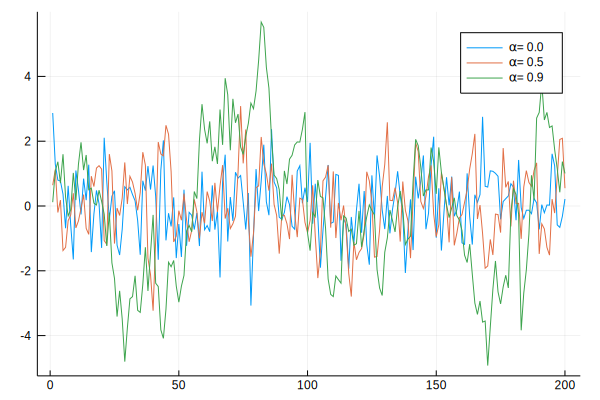

In [67]:
using Plots
using Markdown
T = 200
αs = [0, 0.5, 0.9]
Random.seed!(1942)
plot(1:T, generate_AR1.(αs, T), label=((x -> md"\alpha = $x").(αs)))

### Logistic Map Problem

In [137]:
function logistic_ω_limit_set(r, max_period = 150, relaxation_steps = 1000)
    b = 0.25
    for i = 1:relaxation_steps
        b = r * b * (1 - b)
    end
    result = Array{Float64}(undef, max_period)
    for i = 1:max_period
        result[i] = b = r * b * (1 - b)
    end
    return result
end;

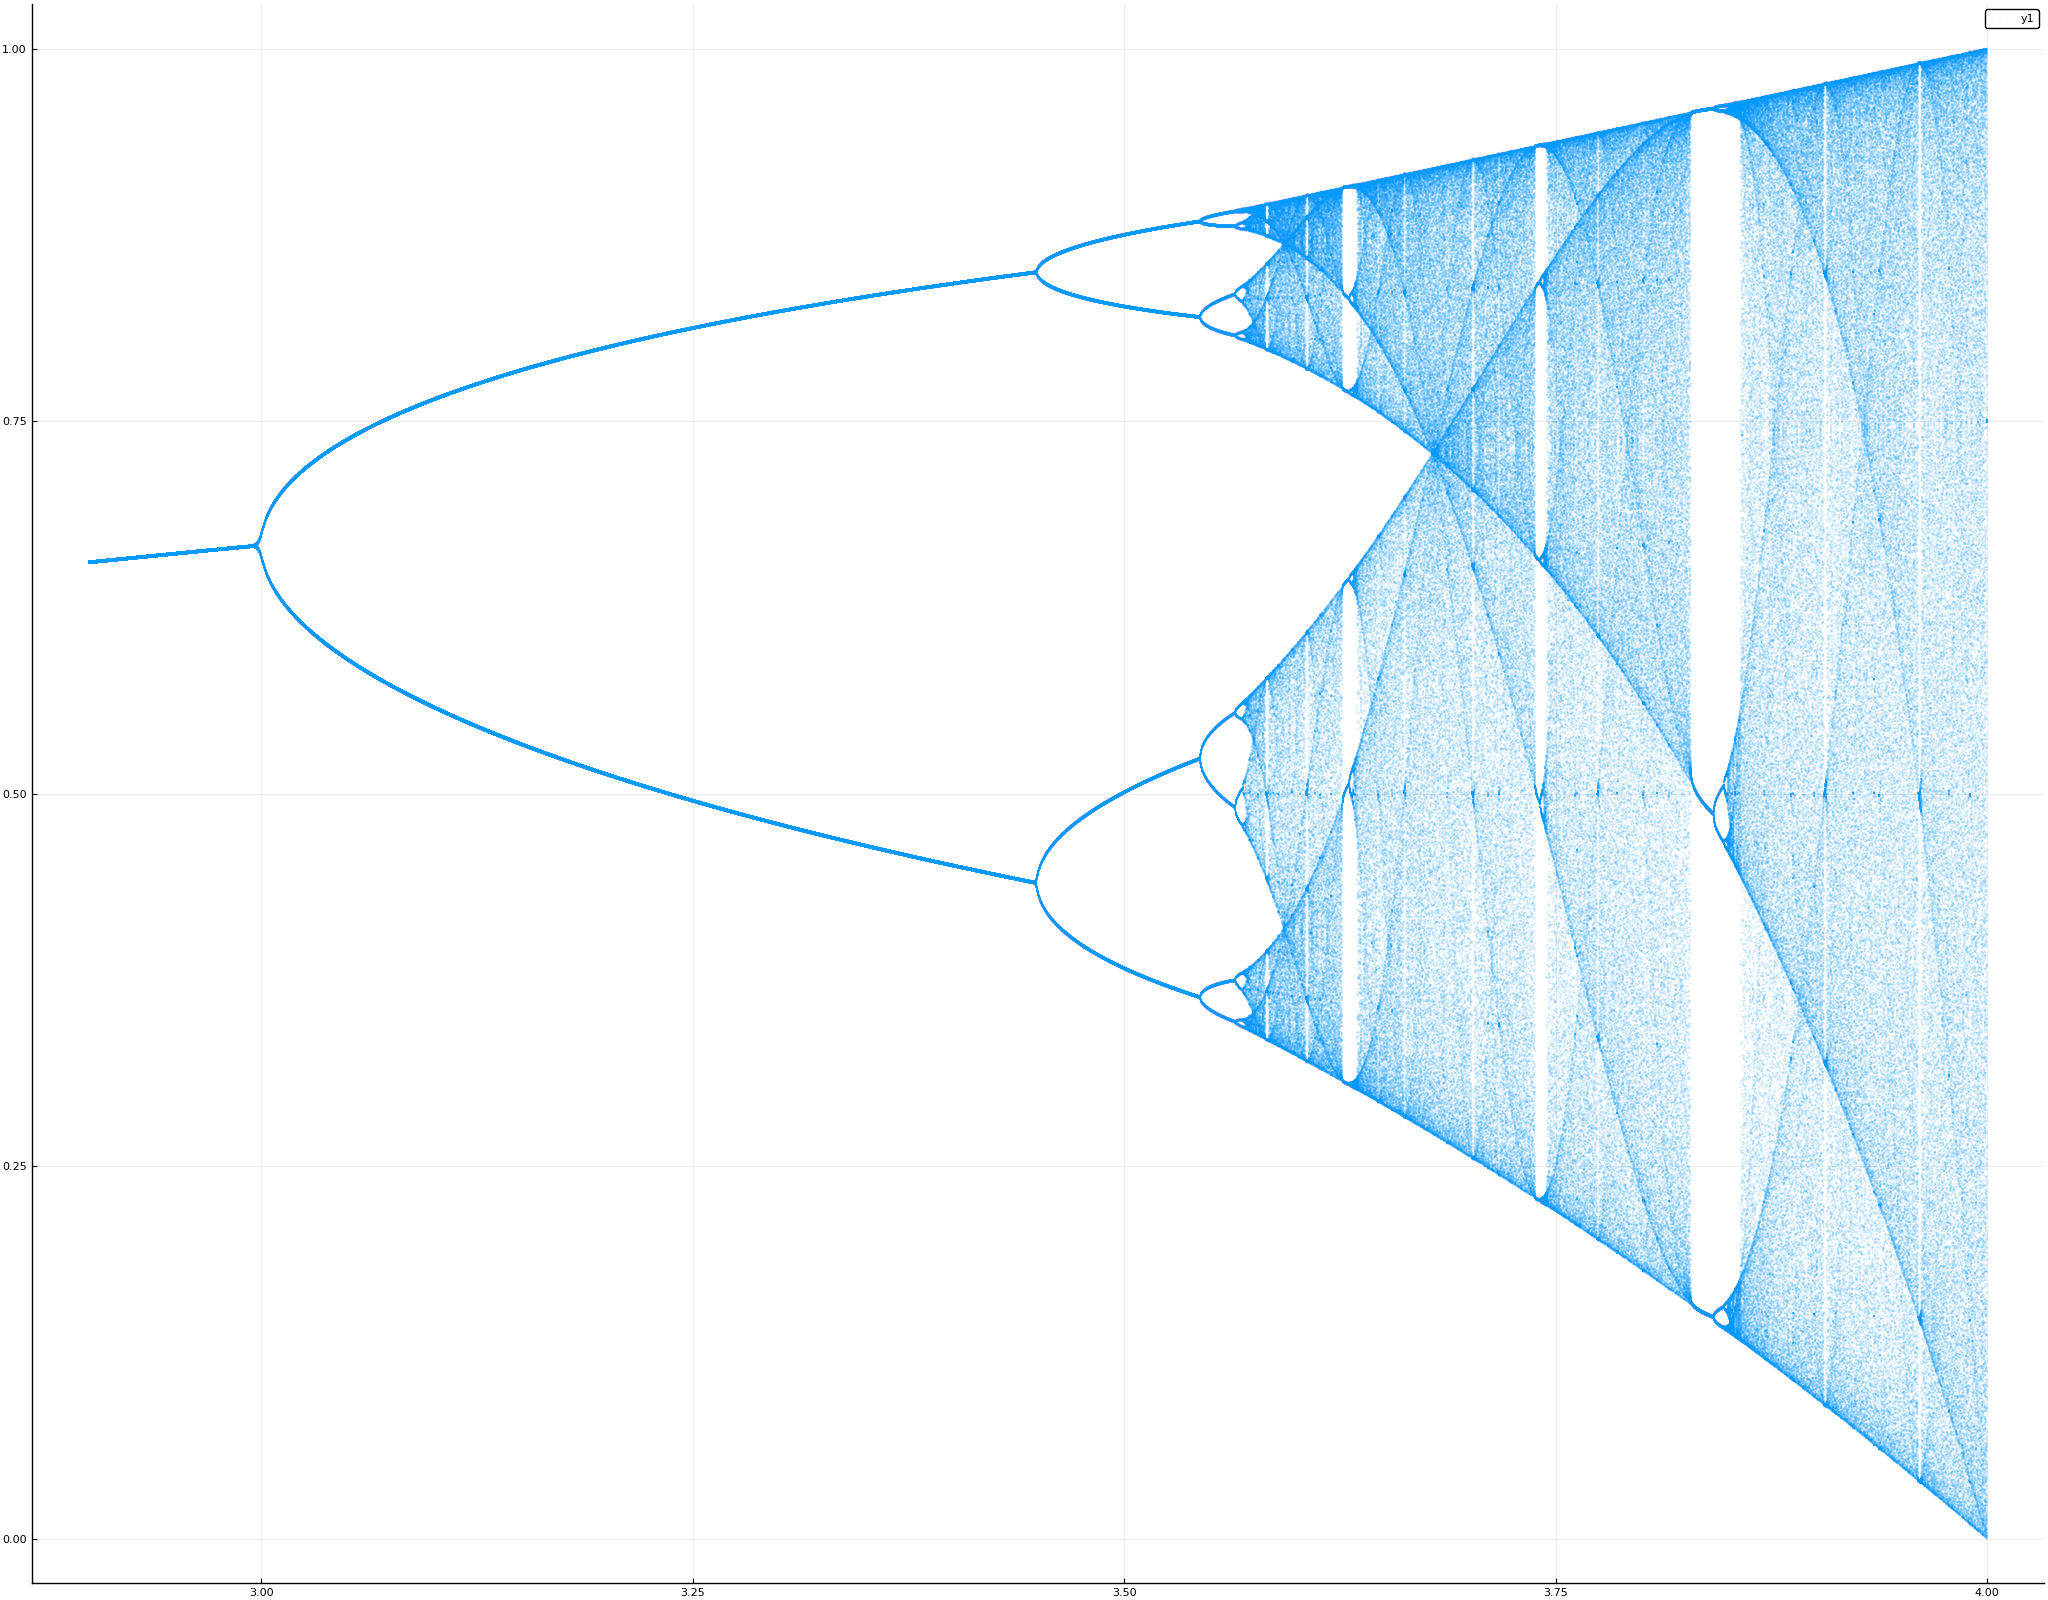

In [138]:
max_period = 150
rs = 2.9:0.0001:4
f(r, max_period) = hcat(fill(r, (max_period,)), logistic_ω_limit_set(r, max_period))
xys = vcat(f.(rs, max_period)...)
pyplot(size=(2048,1600))
plot(xys[:,1], xys[:,2], seriestype=:scatter, markershape=:hline, markeralpha=0.1, markersize=1)